In [51]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import random
import re
import seaborn as sns
import time
import torch
import torch.nn as nn
from nltk.corpus import wordnet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [52]:
nltk.download("punkt")
nltk.download("wordnet")

factory = StemmerFactory()
stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arbaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arbaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
import json


def load_kamus(kamus_file):
    with open(kamus_file, "r", encoding="utf-8") as f:
        kamus = json.load(f)

    print(f"Kamus dimuat dari: {kamus_file}")
    print(f"Jumlah entri dalam kamus: {len(kamus)}")

    return kamus

In [55]:
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        intents = json.load(f)
    print(f"Data intents dimuat dari: {json_file}")
    print(f"Jumlah intents: {len(intents['intents'])}")

    total_patterns = sum(len(intent["patterns"]) for intent in intents["intents"])
    total_responses = sum(len(intent["responses"]) for intent in intents["intents"])
    print(f"Jumlah total patterns: {total_patterns}")
    print(f"Jumlah total responses: {total_responses}")

    return intents

In [56]:
def load_and_print_data(json_file, kamus_file):
    intents = load_data(json_file)
    kamus = load_kamus(kamus_file)

json_file = "intents.json" # contoh file dataset intens
kamus_file = "kamus-fix.json" # contoh file kamus
load_and_print_data(json_file, kamus_file)

Data intents dimuat dari: intents.json
Jumlah intents: 100
Jumlah total patterns: 468
Jumlah total responses: 104
Kamus dimuat dari: kamus-fix.json
Jumlah entri dalam kamus: 308


In [57]:
def translate_with_kamus(word, kamus, patterns):
    word_lower = word.lower()

    if re.match(r"\{.*?\}", word):
        print(f"Kata '{word}' adalah placeholder, tidak diterjemahkan.")
        return word

    if word_lower in patterns:
        print(f"Kata '{word_lower}' sudah ada di patterns, tidak diterjemahkan.")
        return word_lower

    for key, value in kamus.items():
        if isinstance(value["Inggris"], list):
            if word_lower in [v.lower() for v in value["Inggris"]]:
                print(f"Mengubah Kata '{word_lower}' ke '{key}'")
                return key
        elif word_lower == value["Inggris"].lower():
            print(f"Mengubah Kata '{word_lower}' ke '{key}'")
            return key

        if isinstance(value["Sunda"], list):
            if word_lower in [v.lower() for v in value["Sunda"]]:
                print(f"Mengubah Kata '{word_lower}' ke '{key}'")
                return key
        elif word_lower == value["Sunda"].lower():
            print(f"Mengubah Kata '{word_lower}' ke '{key}'")
            return key

    print(f"Kata '{word_lower}' tidak ditemukan di kamus.")
    return word_lower

In [58]:
def apply_kamus_to_sentence(sentence, kamus, patterns):
    tokenized_sentence = nltk.word_tokenize(sentence)
    print(f"Tokenisasi kalimat: {tokenized_sentence}")

    translated_sentence = [
        translate_with_kamus(word, kamus, patterns) for word in tokenized_sentence
    ]

    print(f"Kalimat setelah diterjemahkan: {translated_sentence}")
    return translated_sentence

In [59]:
def preprocess_sentence_with_bert(sentence, kamus, tokenizer, bert_model, patterns):
    print(f"Proses kalimat: {sentence}")

    sentence = apply_kamus_to_sentence(sentence, kamus, patterns)
    sentence_no_stopwords = stopword_remover.remove(" ".join(sentence))
    print(f"Kalimat tanpa kata-kata umum: {sentence_no_stopwords}")

    tokenized_sentence = tokenizer(
        sentence_no_stopwords,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    )

    with torch.no_grad():
        outputs = bert_model(**tokenized_sentence.to(device))
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

    return embedding

In [60]:
def synonym_replacement(sentence, patterns, dictionary):
    words = nltk.word_tokenize(sentence)
    new_sentence = sentence

    for word in words:

        if word.lower() in patterns or re.match(r"\{.*?\}", word):
            print(
                f"Kata '{word}' tidak diganti karena ada di patterns atau placeholder."
            )
            continue

        if word.lower() in patterns:
            print(f"Kata '{word}' ada dalam patterns, tidak diganti.")
            continue

        if word.lower() in dictionary:
            print(f"Kata '{word}' ada dalam kamus, tidak diganti.")
            continue

        synonyms = wordnet.synsets(word)

        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            print(f"Mengganti '{word}' dengan sinonim '{synonym}'")
            new_sentence = new_sentence.replace(word, synonym, 1)

    print("Kalimat hasil:", new_sentence)
    return new_sentence

In [61]:
def preprocess_data_with_kamus(intents, kamus, tokenizer, bert_model):
    xy = []
    tags = []
    patterns = (
        {}
    )  

    for intent in intents["intents"]:
        tag = intent["tag"]
        tags.append(tag)

        for pattern in intent["patterns"]:
            processed_embedding = preprocess_sentence_with_bert(
                pattern, kamus, tokenizer, bert_model, patterns
            )
            xy.append((processed_embedding, tag))

            augmented_pattern = synonym_replacement(pattern, patterns, kamus)

            processed_embedding_augmented = preprocess_sentence_with_bert(
                augmented_pattern, kamus, tokenizer, bert_model, patterns
            )
            xy.append((processed_embedding_augmented, tag))

    return xy, tags

In [62]:
def create_training_data(xy, tags):
    X_train = []
    y_train = []
    for embedding, tag in xy:
        X_train.append(embedding)
        label = tags.index(tag)
        y_train.append(label)

    X_train = torch.stack(X_train)
    y_train = np.array(y_train)
    # print(f"Data pelatihan dibuat dengan ukuran: {X_train.shape}, {y_train.shape}")
    return X_train, y_train

In [63]:
class ChatDataset(Dataset):
    def __init__(self, X, y):
        self.n_samples = len(X)
        self.x_data = X
        self.y_data = y

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples


In [64]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l3(out)
        return out

In [65]:
def train_model_with_kamus(
    json_file,
    kamus_file,
    num_epochs=500,
    batch_size=64,
    learning_rate=0.0001,
    hidden_size=128,
):
    intents = load_data(json_file)
    kamus = load_kamus(kamus_file)

    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    bert_model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

    xy, tags = preprocess_data_with_kamus(intents, kamus, tokenizer, bert_model)
    X_train, y_train = create_training_data(xy, tags)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    input_size = X_train.shape[1]
    output_size = len(tags)
    train_dataset = ChatDataset(X_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_dataset = ChatDataset(X_val, y_val)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = NeuralNet(input_size, hidden_size, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_train_accuracy = 0.0
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            outputs = model(words)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        elapsed_time = time.time() - start_time

        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy

        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        with torch.no_grad():
            for words, labels in val_loader:
                words = words.to(device)
                labels = labels.to(dtype=torch.long).to(device)

                outputs = model(words)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        losses.append(avg_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 100 == 0 or epoch == 0: 
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Loss: {avg_loss:.4f}, "
                f"Train Accuracy: {train_accuracy:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, "
                f"Val Accuracy: {val_accuracy:.4f}, "
                f"Time: {elapsed_time:.2f}s"
            )

    print("Training complete!")

    data = {
        "model_state": model.state_dict(),
        "input_size": input_size,
        "output_size": output_size,
        "hidden_size": hidden_size,
        "tags": tags,
    }
    torch.save(data, "model-fix.pth")
    print("Model saved as model-fix.pth")

    print(f"\nFinal Training Loss: {losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    print(f"\nFinal Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

    print(f"\nBest Training Accuracy: {best_train_accuracy:.4f}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

    return (
        model,
        train_loader,
        val_loader,
        losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        tags,
        X_train,
        X_val,
        y_train,
        y_val,
        kamus,
    )


In [66]:
(
    model,
    train_loader,
    val_loader,
    losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    tags,
    X_train,
    X_val,
    y_train,
    y_val,
    kamus
) = train_model_with_kamus("intents.json", "kamus-fix.json")

Data intents dimuat dari: intents.json
Jumlah intents: 100
Jumlah total patterns: 468
Jumlah total responses: 104
Kamus dimuat dari: kamus-fix.json
Jumlah entri dalam kamus: 308
Proses kalimat: Halo
Tokenisasi kalimat: ['Halo']
Kata 'halo' tidak ditemukan di kamus.
Kalimat setelah diterjemahkan: ['halo']
Kalimat tanpa kata-kata umum: halo
Mengganti 'Halo' dengan sinonim 'aura'
Kalimat hasil: aura
Proses kalimat: aura
Tokenisasi kalimat: ['aura']
Kata 'aura' tidak ditemukan di kamus.
Kalimat setelah diterjemahkan: ['aura']
Kalimat tanpa kata-kata umum: aura
Proses kalimat: Hi
Tokenisasi kalimat: ['Hi']
Kata 'hi' tidak ditemukan di kamus.
Kalimat setelah diterjemahkan: ['hi']
Kalimat tanpa kata-kata umum: hi
Mengganti 'Hi' dengan sinonim 'hello'
Kalimat hasil: hello
Proses kalimat: hello
Tokenisasi kalimat: ['hello']
Kata 'hello' tidak ditemukan di kamus.
Kalimat setelah diterjemahkan: ['hello']
Kalimat tanpa kata-kata umum: hello
Proses kalimat: Hai
Tokenisasi kalimat: ['Hai']
Kata 'hai

In [67]:

def evaluate_model(model, data_loader, tags):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    unique_classes = sorted(set(all_labels))
    filtered_tags = [tags[i] for i in unique_classes if i < len(tags)]

    return accuracy, f1, precision, recall, conf_matrix

In [68]:
train_accuracy, train_f1, train_precision, train_recall, train_conf_matrix = (
    evaluate_model(model, train_loader, tags)
)
val_accuracy, val_f1, val_precision, val_recall, val_conf_matrix = evaluate_model(
    model, val_loader, tags
)

c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [69]:

def print_confusion_matrix_metrics(conf_matrix, labels):
    total = np.sum(conf_matrix)  
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        TN = total - (TP + FP + FN)
        accuracy = (TP + TN) / total
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0
        )
        print(f"Metrics for class: {labels[i]}")
        print(f"True Positives (TP): {TP}")
        print(f"False Positives (FP): {FP}")
        print(f"False Negatives (FN): {FN}")
        print(f"True Negatives (TN): {TN}")
        print(f"Accuracy: (TP + TN) / Total = ({TP} + {TN}) / {total} = {accuracy:.4f}")
        print(f"Precision: TP / (TP + FP) = {TP} / ({TP} + {FP}) = {precision:.4f}")
        print(f"Recall: TP / (TP + FN) = {TP} / ({TP} + {FN}) = {recall:.4f}")
        print(f"F1 Score: 2 * (Precision * Recall) / (Precision + Recall) = {f1:.4f}")
        print("-" * 50)


print_confusion_matrix_metrics(train_conf_matrix, tags)  
print_confusion_matrix_metrics(val_conf_matrix, tags)  

Metrics for class: halo
True Positives (TP): 11
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 737
Accuracy: (TP + TN) / Total = (11 + 737) / 748 = 1.0000
Precision: TP / (TP + FP) = 11 / (11 + 0) = 1.0000
Recall: TP / (TP + FN) = 11 / (11 + 0) = 1.0000
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) = 1.0000
--------------------------------------------------
Metrics for class: pagi
True Positives (TP): 4
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 744
Accuracy: (TP + TN) / Total = (4 + 744) / 748 = 1.0000
Precision: TP / (TP + FP) = 4 / (4 + 0) = 1.0000
Recall: TP / (TP + FN) = 4 / (4 + 0) = 1.0000
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) = 1.0000
--------------------------------------------------
Metrics for class: siang
True Positives (TP): 4
False Positives (FP): 0
False Negatives (FN): 0
True Negatives (TN): 744
Accuracy: (TP + TN) / Total = (4 + 744) / 748 = 1.0000
Precision: TP / (TP + FP) = 4 / (4 + 0) = 

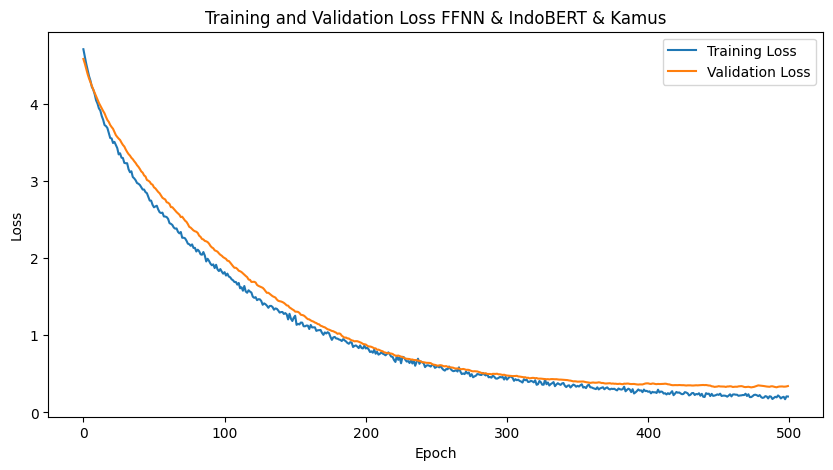

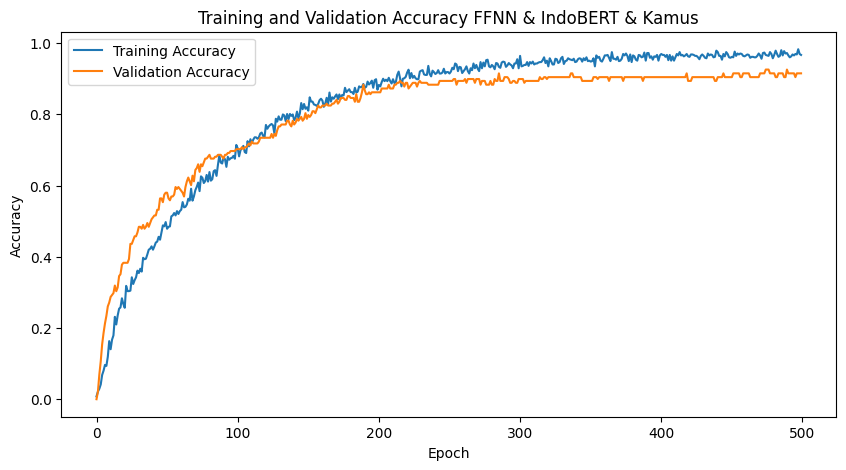

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss FFNN & IndoBERT & Kamus")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy")
plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy FFNN & IndoBERT & Kamus")
plt.legend()
plt.show()

Training Data:
Accuracy: 0.9947
F1 Score: 0.9927
Precision: 0.9917
Recall: 0.9947


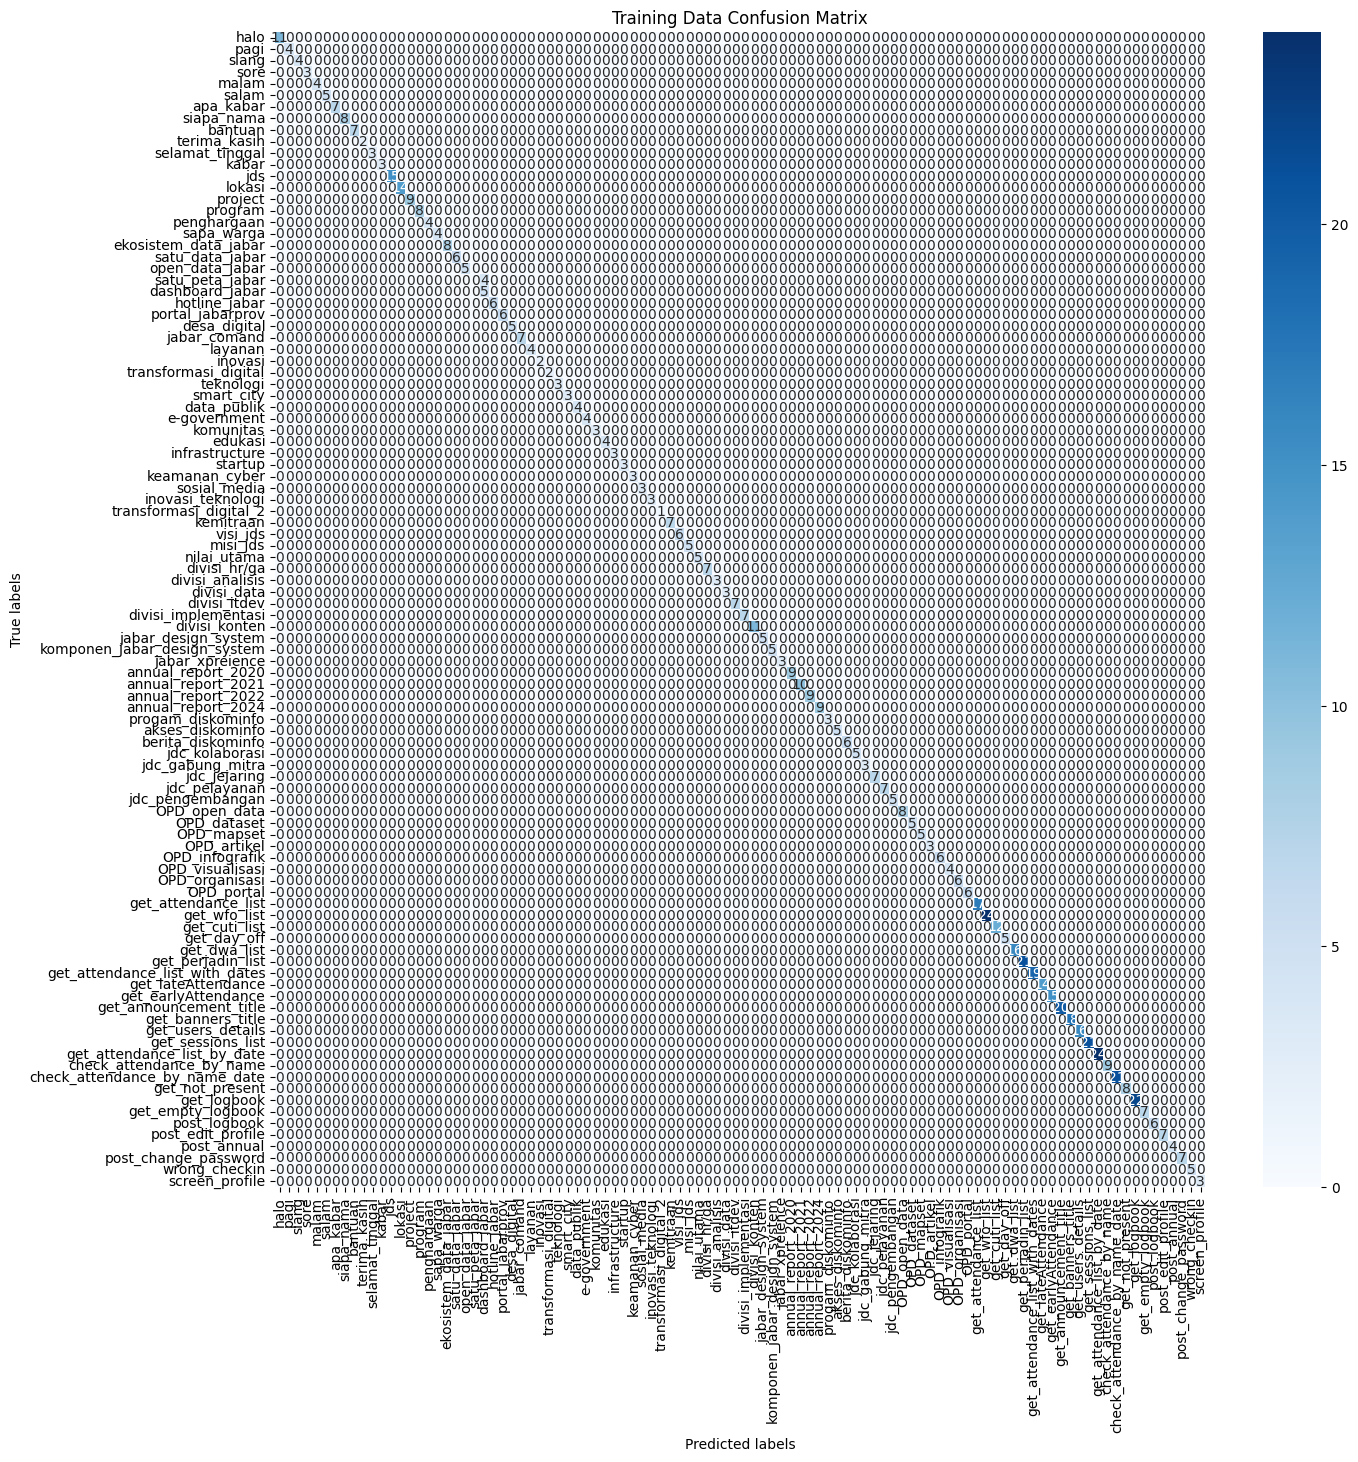

In [71]:
print("Training Data:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")

plt.figure(figsize=(15, 15))
sns.heatmap(
    train_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=tags,
    yticklabels=tags,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Training Data Confusion Matrix")
plt.show()

Validation Data:
Accuracy: 0.9149
F1 Score: 0.9061
Precision: 0.9335
Recall: 0.9149


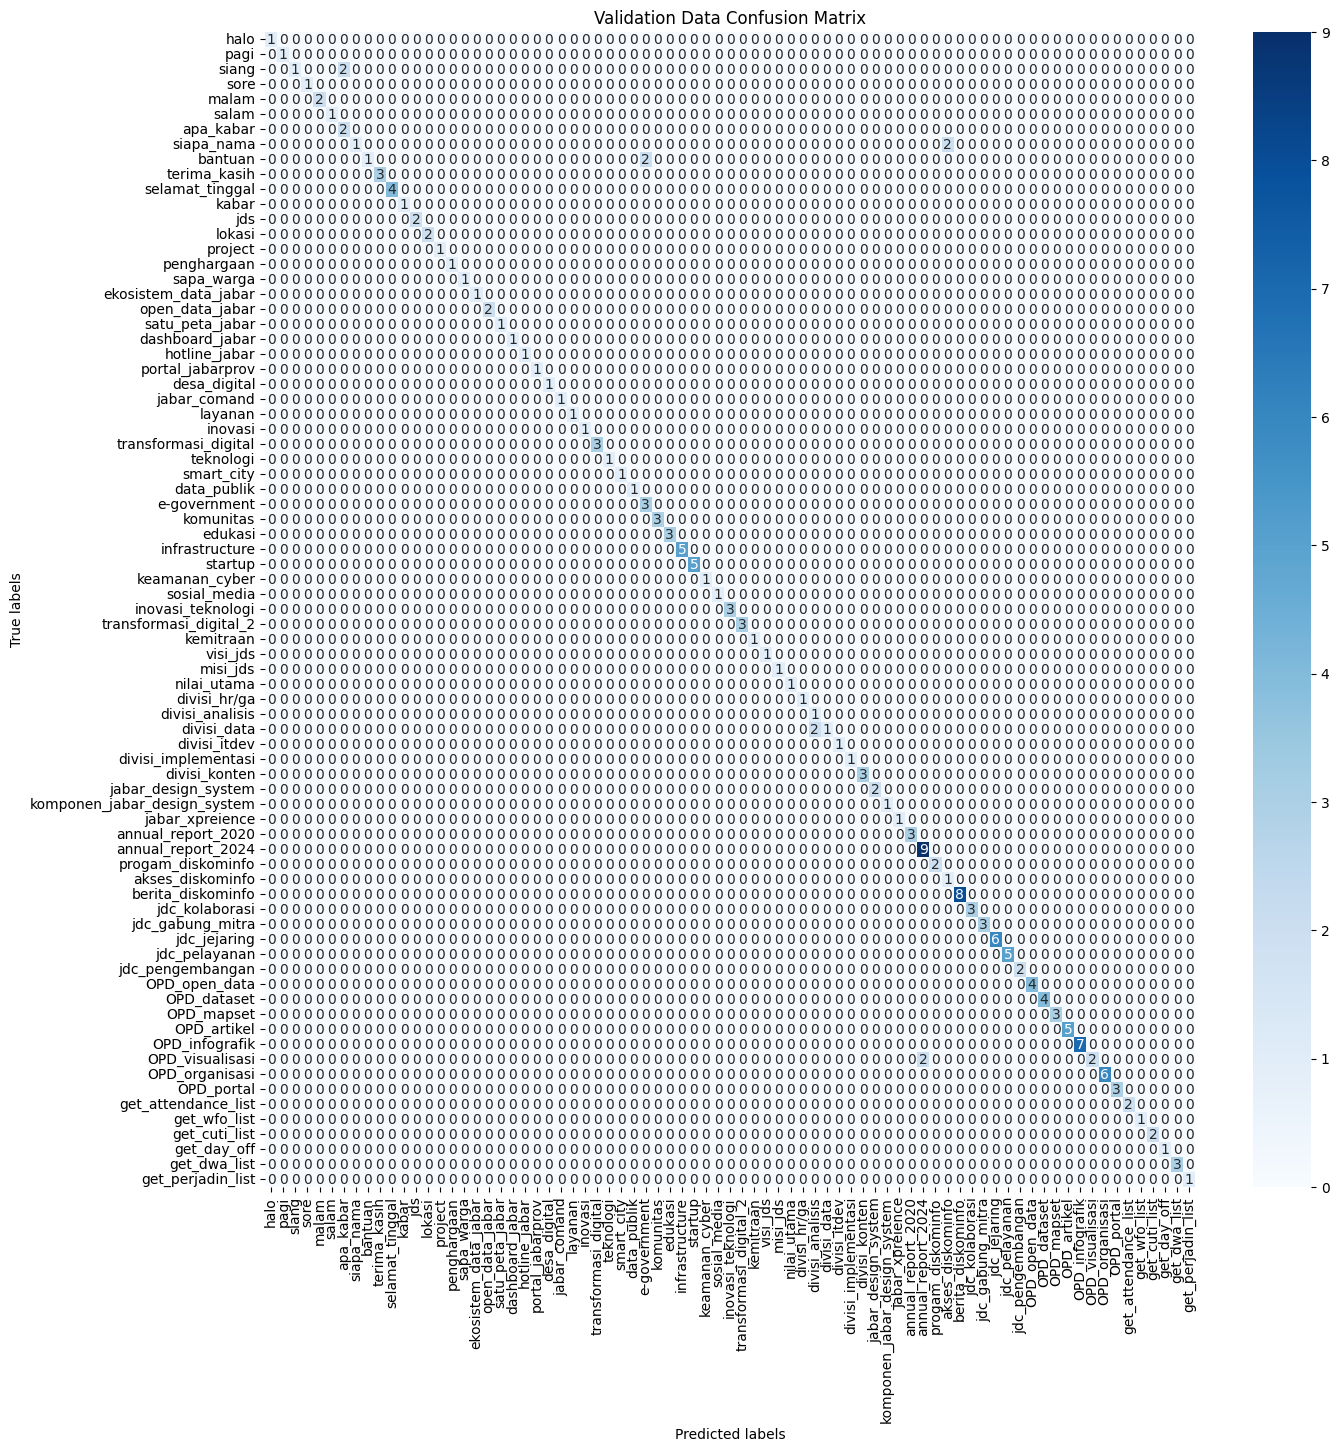

In [73]:
def remove_empty_rows_and_columns(conf_matrix, labels):

    non_empty_indices = np.where(
        ~(conf_matrix.sum(axis=0) == 0) & ~(conf_matrix.sum(axis=1) == 0)
    )[0]


    filtered_conf_matrix = conf_matrix[np.ix_(non_empty_indices, non_empty_indices)]
    filtered_labels = [labels[i] for i in non_empty_indices]

    return filtered_conf_matrix, filtered_labels


filtered_val_conf_matrix, filtered_val_tags = remove_empty_rows_and_columns(
    val_conf_matrix, tags
)


print("Validation Data:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")


plt.figure(figsize=(15, 15))
sns.heatmap(
    filtered_val_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=filtered_val_tags,
    yticklabels=filtered_val_tags,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Validation Data Confusion Matrix")
plt.show()

In [74]:
def load_model(model_path):
    data = torch.load(model_path)
    model = NeuralNet(data["input_size"], data["hidden_size"], data["output_size"])
    model.load_state_dict(data["model_state"])
    model.eval()
    return model, data["tags"]


def get_bert_features(sentence, tokenizer, bert_model):
    tokenized_sentence = tokenizer(
        sentence, return_tensors="pt", padding=True, truncation=True, max_length=512
    )
    with torch.no_grad():
        outputs = bert_model(**tokenized_sentence.to(device))
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding


def get_response(tag, intents):
    for intent in intents["intents"]:
        if intent["tag"] == tag:
            return random.choice(intent["responses"])
    return "Tidak ada respon yang tersedia"

In [75]:
def predict_without_kamus(input_sentence, model, tags, tokenizer, bert_model):
    print(f"\nMemproses input tanpa kamus: {input_sentence}")
    features = get_bert_features(input_sentence, tokenizer, bert_model)
    features = np.array(features, dtype=np.float32)
    bag = torch.from_numpy(features).unsqueeze(0)

    with torch.no_grad():
        output = model(bag)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_tag = tags[predicted_class.item()]
        predicted_prob = probabilities[0][predicted_class.item()].item()

    print(f"Predicted tag tanpa kamus: {predicted_tag}")
    print(f"Probability tanpa kamus: {predicted_prob:.4f}")

    return predicted_tag, predicted_prob


def predict_with_kamus(
    input_sentence, model, tags, kamus, tokenizer, bert_model, patterns
):
    print(f"\nMemproses input dengan kamus: {input_sentence}")

    replaced_sentence = synonym_replacement(input_sentence, patterns, kamus)
    print(f"Kalimat setelah synonym replacement: {replaced_sentence}")

    translated_sentence = apply_kamus_to_sentence(replaced_sentence, kamus, patterns)

    print(f"Kalimat input setelah diterjemahkan: {' '.join(translated_sentence)}")

    sentence_no_stopwords = stopword_remover.remove(" ".join(translated_sentence))

    features = get_bert_features(sentence_no_stopwords, tokenizer, bert_model)
    features = np.array(features, dtype=np.float32)
    bag = torch.from_numpy(features).unsqueeze(0)

    with torch.no_grad():
        output = model(bag)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_tag = tags[predicted_class.item()]
        predicted_prob = probabilities[0][predicted_class.item()].item()

    print(f"Predicted tag dengan kamus: {predicted_tag}")
    print(f"Probability dengan kamus: {predicted_prob:.4f}")

    return predicted_tag, predicted_prob

In [88]:
import re


def predict_and_respond(user_input, model_path, kamus_file, intents_file):
    model, tags = load_model(model_path)
    kamus = load_kamus(kamus_file)
    intents = load_data(intents_file)

    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    bert_model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

    patterns = []
    for intent in intents["intents"]:
        patterns.extend(intent["patterns"])

    tag_no_kamus, prob_no_kamus = predict_without_kamus(
        user_input, model, tags, tokenizer, bert_model
    )
    response_no_kamus = get_response(tag_no_kamus, intents)
    print(f"Response tanpa kamus: {response_no_kamus}\n")

    tag_with_kamus, prob_with_kamus = predict_with_kamus(
        user_input, model, tags, kamus, tokenizer, bert_model, patterns
    )
    response_with_kamus = get_response(tag_with_kamus, intents)
    print(f"Response dengan kamus: {response_with_kamus}")

    print(
        f"\n1. Prediksi tag tanpa kamus: {tag_no_kamus}, Probability: {prob_no_kamus:.4f}"
    )
    print(
        f"2. Prediksi tag dengan kamus: {tag_with_kamus}, Probability: {prob_with_kamus:.4f}"
    )

    final_response = None
    if prob_no_kamus > 0.75 and prob_with_kamus > 0.75:
        final_response = (
            response_with_kamus
            if prob_with_kamus > prob_no_kamus
            else response_no_kamus
        )
    elif prob_no_kamus > 0.75:
        final_response = response_no_kamus
    elif prob_with_kamus > 0.75:
        final_response = response_with_kamus
    else:
        final_response = "Maaf, saya tidak mengerti"

    print(f"\nRespons final: {final_response}")

In [99]:
def main():
    model_path = "model-fix.pth"
    kamus_file = "kamus-fix.json"
    intents_file = "intents.json"

    user_input = input("Anda: ")
    predict_and_respond(user_input, model_path, kamus_file, intents_file)


if __name__ == "__main__":
    main()

Kamus dimuat dari: kamus-fix.json
Jumlah entri dalam kamus: 308
Data intents dimuat dari: intents.json
Jumlah intents: 100
Jumlah total patterns: 468
Jumlah total responses: 104

Memproses input tanpa kamus: How Carana Tingali List Logbook?
Predicted tag tanpa kamus: post_logbook
Probability tanpa kamus: 0.4526
Response tanpa kamus: 1. Menu Post Logbook  
2. Isikan semua yang ditandai (*) yang berarti wajib 
3. Cek kembali isian logbok apakah sudah sesuai 
4. Klik tombol submit untuk mengirim logbook 
5. Tunggu proses lalu otomatis ke halaman logbook.

Untuk menuju ke halaman logbook, silakan klik tautan berikut .


Memproses input dengan kamus: How Carana Tingali List Logbook?
Mengganti 'List' dengan sinonim 'list'
Kata 'Logbook' ada dalam kamus, tidak diganti.
Kalimat hasil: How Carana Tingali list Logbook?
Kalimat setelah synonym replacement: How Carana Tingali list Logbook?
Tokenisasi kalimat: ['How', 'Carana', 'Tingali', 'list', 'Logbook', '?']
Mengubah Kata 'how' ke 'Gimana'
Meng